In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold
from statistics import mean
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import loguniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.ensemble import GradientBoostingClassifier
warnings.filterwarnings('ignore')

# HW3 Sarcopenia

## I. Data pre-processing

5.The dataset has 1303 samples with 39 columns. The target variable is 'SARCOPENIA'. Do not use `STAR’ variable in your analysis.

Read the data and print the data information, the shape of the data and explore it. You may need to create new variables such as Education level, Smoking, Gender, Exercise, etc.

### 1) Import data

In [ ]:
df = pd.read_csv('/work/HW3/HW3_dataset_translated.csv', index_col=False)
df.columns = df.columns.str.strip() # remove eventual trailing spaces in column names
df.head()

,Unnamed: 0,MMSE,Age,Weight,Height,Waist,Hip,Smoking,Smoking (packet/year),Alcohol,...,Gait speed,Low grip strength,Grip strength,SARCOPENIA,STAR,BMI,Gender,Occupation_trans,Education_trans,Working_status_trans
0,0,NaN,64,66.0,155.0,89.0,104.0,0.0,0,0,...,1.28,0.0,28.0,0.0,1.00,27.40,f,officer,high school,retire
1,1,NaN,53,55.0,150.0,77.0,97.0,0.0,0,0,...,1.47,1.0,16.0,0.0,1.84,24.40,f,NaN,NaN,NaN
2,2,24.0,56,56.0,150.0,112.0,125.0,0.0,0,0,...,0.80,0.0,23.0,0.0,1.48,36.00,f,housewife,illiterate,retired
3,3,NaN,58,75.0,160.0,113.0,NaN,0.0,0,0,...,1.34,0.0,23.0,0.0,1.12,29.30,f,housewife,illiterate,unemployed
4,4,30.0,55,72.0,157.0,98.0,104.0,1.0,4,0,...,1.09,NaN,21.0,0.0,1.45,29.21,f,housewife,primary school,not working


In [ ]:
print("Column names :", df.columns)

Column names : Index(['Unnamed: 0', 'MMSE', 'Age', 'Weight', 'Height', 'Waist', 'Hip',
       'Smoking', 'Smoking (packet/year)', 'Alcohol', 'DM', 'DM duration',
       'İnsülin', 'DM drug', 'Hiperlipidemi', 'Dyslipidemia duration',
       'Dyslipidemia drugs', 'KAH', 'KAH duration', 'Hipotiroidi', 'ASTIM',
       'KOAH', 'OP', 'Other(s)', 'HT', 'Anti-HT drug type', 'HT duration',
       'Education', 'Occupation', 'Working Status', 'Exercise', 'LowCST',
       'CST', 'Gait speed', 'Low grip strength', 'Grip strength', 'SARCOPENIA',
       'STAR', 'BMI', 'Gender', 'Occupation_trans', 'Education_trans',
       'Working_status_trans'],
      dtype='object')


In [ ]:
print("size of the dataset : ", df.shape)

size of the dataset :  (1303, 43)


### 2) Dealing with missing values

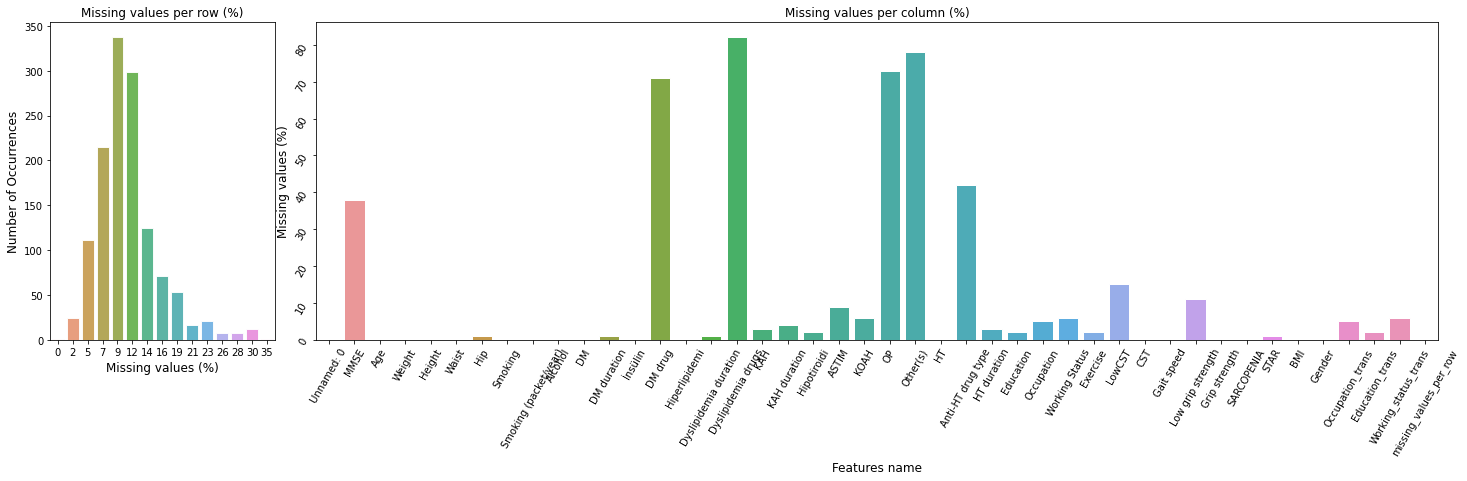

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 5), gridspec_kw={'width_ratios': [3, 15]})
fig.tight_layout()

# Percentage of missing values per row

missing_values_per_row = df.isnull().sum(axis=1).tolist()
df["missing_values_per_row"] = [round(x/df.shape[1]*100) for x in missing_values_per_row]
missingrows = df["missing_values_per_row"].value_counts()
sns.set(style="darkgrid")
sns.barplot(missingrows.index, missingrows.values, alpha=0.9, ax=ax1)
ax1.set_title('Missing values per row (%)')
ax1.set_ylabel('Number of Occurrences', fontsize=12)
ax1.set_xlabel('Missing values (%)', fontsize=12)

# Percentage of missing values per column

sns.barplot(df.columns, round(df.isnull().sum(axis=0)/df.shape[0] * 100), ax=ax2, linewidth=1)
ax2.set_title('Missing values per column (%)')
ax2.set_ylabel('Missing values (%)', fontsize=12)
ax2.set_xlabel('Features name', fontsize=12)
ax2.tick_params(labelrotation=60)


In [ ]:
# Percentage of missing values per column
# print(round(df.isnull().sum(axis=0)/df.shape[0] * 100))

# Dropping the columns with more than 30% of missing values
col_to_drop = []
for col in df.columns:
    treshold = df.shape[0]*0.3
    if(df[col].isnull().sum()>treshold):
        col_to_drop.append(col)
print("Dropping the following columns :", col_to_drop)
df.drop(columns=col_to_drop, inplace=True)
df.drop(columns=['Occupation', 'Education', 'Working Status', 'Unnamed: 0'], inplace=True)

Dropping the following columns : ['MMSE', 'DM drug', 'Dyslipidemia drugs', 'OP', 'Other(s)', 'Anti-HT drug type']


In [ ]:
# Dropping the rows with more than 15% of missing values
print("Size before dropping some rows : ", df.shape[0])
df.drop(df[df.missing_values_per_row >= 15].index, inplace=True)
print("Size after dropping some rows : ", df.shape[0])

Size before dropping some rows :  1303
Size after dropping some rows :  1112


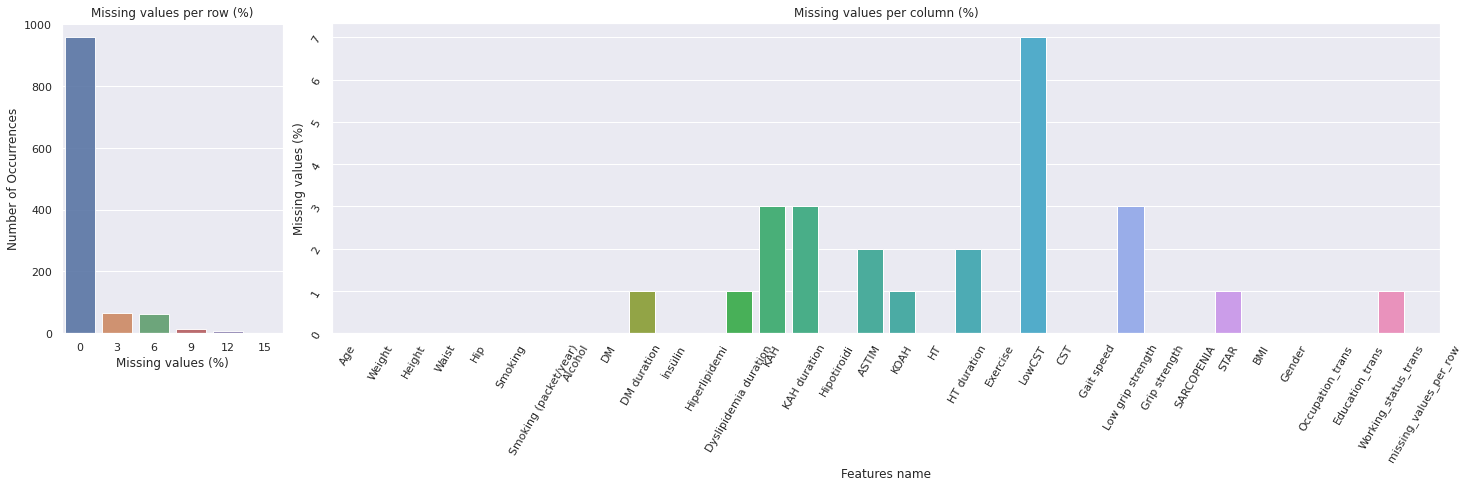

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 5), gridspec_kw={'width_ratios': [3, 15]})
fig.tight_layout()

# Percentage of missing values per row

missing_values_per_row = df.isnull().sum(axis=1).tolist()
df["missing_values_per_row"] = [round(x/df.shape[1]*100) for x in missing_values_per_row]
missingrows = df["missing_values_per_row"].value_counts()
sns.set(style="darkgrid")
sns.barplot(missingrows.index, missingrows.values, alpha=0.9, ax=ax1)
ax1.set_title('Missing values per row (%)')
ax1.set_ylabel('Number of Occurrences', fontsize=12)
ax1.set_xlabel('Missing values (%)', fontsize=12)

# Percentage of missing values per column

sns.barplot(df.columns, round(df.isnull().sum(axis=0)/df.shape[0] * 100), ax=ax2, linewidth=1)
ax2.set_title('Missing values per column (%)')
ax2.set_ylabel('Missing values (%)', fontsize=12)
ax2.set_xlabel('Features name', fontsize=12)
ax2.tick_params(labelrotation=60)

Now that we drop columns and rows with too many missing data, the remaining one have less than 15% of missing data. We will impute them later using knn imputer. 

### 3) Transforming categorical data

In [ ]:
# Get categorical columns list
numerical_cols = []
categorical_cols = []
for col in df.columns:
    if(df[col].dtype == 'object'):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

print("List of categorical features : ", categorical_cols)

List of categorical features :  ['Smoking (packet/year)', 'Alcohol', 'Exercise', 'Gender', 'Occupation_trans', 'Education_trans', 'Working_status_trans']


In [ ]:
# Perform some basic cleaning
for col in categorical_cols:
    df[col] = df[col].str.lower() # to lowercase
    df[col] = df[col].str.strip() # remove trailing spaces

In [ ]:
df[categorical_cols].head(5)

,Smoking (packet/year),Alcohol,Exercise,Gender,Occupation_trans,Education_trans,Working_status_trans
0,0,0,0,f,officer,high school,retire
2,0,0,0,f,housewife,illiterate,retired
3,0,0,0,f,housewife,illiterate,unemployed
5,30,social,1-2/week,m,police officer,high school,retired
6,11.5,social,0,f,domestic,secondary school,full-time/part-time work


a) Focus on Smoking

In [ ]:
# Check categories in 'Smoking (packet/year)'
print("There is some weird values in the column : ", df['Smoking (packet/year)'].unique())

# Transform weird values to number 

df['Smoking (packet/year)'].replace({'ex smoker 300/year 9 yrs back':'300','ex smoker 3years/ unlimited':np.NaN}, inplace=True)#, 'ex smoker 3years/ unlimited':None

nb_packets = []
for val in df['Smoking (packet/year)']:
    if("smoker" in str(val)):
        packets = [float(s) for s in re.findall(r'\b\d+\b', str(val))][0]
    elif("years" in str(val)):
        packets = [float(s) for s in re.findall(r'\b\d+\b', str(val))][0]
    else:
        packets = float(val)
    nb_packets.append(packets)

# Cast column to float 
df['Smoking (packet/year)'] = nb_packets
df['Smoking (packet/year)'] = df['Smoking (packet/year)'].astype(float)

# Impute the NaN value with 0 if not a smoker and mean if a smoker
df.loc[df.Smoking == 0, 'Smoking (packet/year)'] = 0
mean_packets = df.loc[df['Smoking (packet/year)']>0, ['Smoking (packet/year)']].mean()
df['Smoking (packet/year)'].replace({np.NaN:mean_packets[0]}, inplace=True)

There is some weird values in the column :  ['0' '30' '11.5' '15' '25' '35' '100' '70' '5' '45' '12' '10' '150' '40'
 '14' '1' '0.1' '20' '72' '21' '17' '50' '2' '20/ex-smoker' '104' '7.5'
 '8' '32' 'shisha for 20 years' '60' '18' 'ex smoker 300/year 9 yrs back'
 '3' '6' '13' '80' '46' 'former smoker: 3' '40/ex-smoker' '9' '4' '88'
 '65' '12.5' '2.5' 'ex smoker: 30' '51' '29' 'ex smoker: 25' '90' '44'
 '75' '36' '24' '64' '28' '7' nan '52' '34' '16' '156' '43' '27' '55'
 'ex smoker 3years/ unlimited']


b) Focus on Alcohol

In [ ]:
print("Categories in feature Alcohol : ", df['Alcohol'].unique())
df['Alcohol'].replace({'0':'abstemious'}, inplace=True)
print("New categories in feature Alcohol : ", df['Alcohol'].unique())

Categories in feature Alcohol :  ['0' 'social' 'regular']
New categories in feature Alcohol :  ['abstemious' 'social' 'regular']


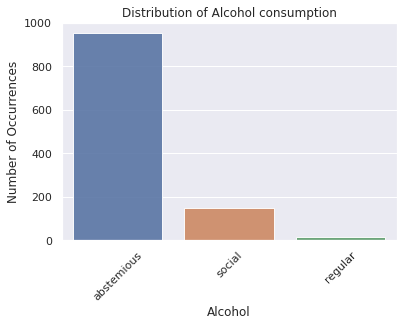

In [ ]:
alcohol_count = df["Alcohol"].value_counts()
sns.set(style="darkgrid")
sns.barplot(alcohol_count.index, alcohol_count.values, alpha=0.9)
plt.title('Distribution of Alcohol consumption')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Alcohol', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Maybe we should group social and regular together 
# df.Alcohol.replace({'abstemious':'no', 'social':'yes', 'regular':'yes'}, inplace=True)

c) Focus on Gender

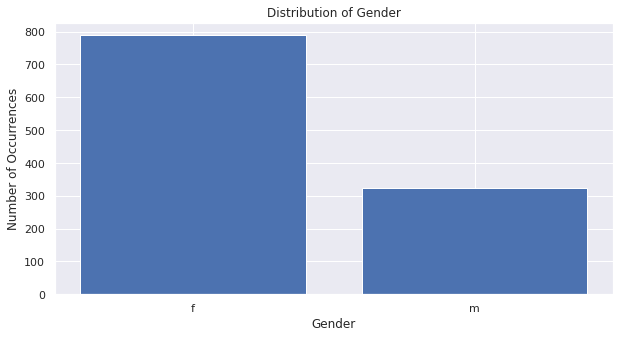

In [ ]:
# Distribution of gender shows an imbalanced dataset
fig = plt.figure(figsize = (10, 5))
gender_count = df["Gender"].value_counts()
plt.bar(gender_count.index, gender_count.values)
plt.title('Distribution of Gender')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

d) Focus on Working Status

In [ ]:
df['Working_status_trans'].unique()

array(['retire', 'retired', 'unemployed', 'full-time/part-time work',
       'not working', 'retired or not working', 'working', 'none',
       'housewife', 'full time', '#ref!', 'full/part time',
       'full/part time work', 'working full/part time', 'rejection', nan,
       'part time', 'full time work', 'part time work',
       'actively working'], dtype=object)

In [ ]:
df['Working_status_trans'].replace({'retire':'retired', 'retired or not working':'retired', 'retd':'retired'}, inplace=True)
df['Working_status_trans'].replace({'not working':'unemployed', 'abstinence':'unemployed', 'none':'unemployed', 'çalışmıyor':'unemployed', 'evhanımı':'unemployed', 'retired or not working':'unemployed'},inplace=True)
df['Working_status_trans'].replace({'part time':'part-time', 'part time work':'part-time', 'abstinence':'part-time', 'none':'part-time'}, inplace=True)
df['Working_status_trans'].replace({'fulltime':'full-time', 'full time work':'full-time', 'full time':'full-time'}, inplace=True)
df['Working_status_trans'].replace({'working full/part time':'full-time/part-time work','full time/part-time work':'full-time/part-time work', 'full/part time work':'full-time/part-time work', 'tam/kısmi zamanlı çalışıyor':'full-time/part-time work', 'ull-time/part-time work':'full-time/part-time work', 'full/part time':'full-time/part-time work', 'tam/kısmi zamnalı çalışıyor':'full-time/part-time work'}, inplace=True)
df['Working_status_trans'].replace({'actively working':'working'}, inplace=True)
df['Working_status_trans'].replace({'full-time/part-time work':'working', 'full-time':'working', 'part-time':'working'}, inplace=True)
df['Working_status_trans'].replace({'#ref!':np.NaN}, inplace=True)
df['Working_status_trans'].replace({'housewife':'unemployed', 'rejection':'unemployed'}, inplace=True)

In [ ]:
df['Working_status_trans'].value_counts()

retired       631
unemployed    239
working       235
Name: Working_status_trans, dtype: int64

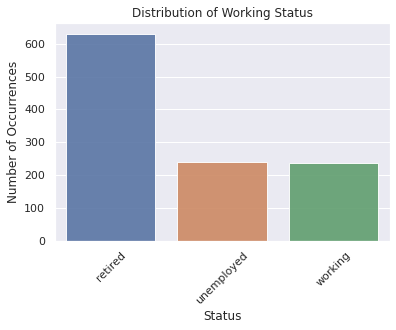

In [ ]:
working_count = df["Working_status_trans"].value_counts()
sns.set(style="darkgrid")
sns.barplot(working_count.index, working_count.values, alpha=0.9)
plt.title('Distribution of Working Status')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Status', fontsize=12)
plt.xticks(rotation=45)
plt.show()

e) Focus on Education

In [ ]:
print(df['Education_trans'].unique())

['high school' 'illiterate' 'secondary school' 'primary school'
 'university' 'highschool' 'none']


In [ ]:
df.Education_trans.replace({'none':'illiterate', 'highschool':'high school'}, inplace=True)

In [ ]:
df['Education_trans'].unique()

array(['high school', 'illiterate', 'secondary school', 'primary school',
       'university'], dtype=object)

f) Focus on Occupation

In [ ]:
occ_list = df['Occupation_trans'].unique().tolist()
occ_list = [str(x) for x in occ_list]
occ_list.sort()
occ_list

['academician',
 'accountant',
 'administrative assistant',
 'administrative employee',
 'administrative worker',
 'administrator in the ministry of electricity',
 'advocate',
 'army officer',
 'artisan',
 'auto mechanic',
 'bank clerk',
 'bank retired',
 'bank worker',
 'banker',
 'beautician',
 'boilermaking',
 'border control',
 'business',
 'butcher',
 'car cleaner',
 'car fixer',
 'care worker',
 'caregiver',
 'carpenter',
 'carrier',
 'chauffeur',
 'chef',
 'chemist',
 'civil servant',
 'cleaner',
 'cleaner perconel',
 'cleaning staff',
 'cleaning worker',
 'clerk',
 'commercial',
 'company manager',
 'concierge',
 'construction worker',
 'constructor',
 'contractor',
 'cook',
 'cook, cleaning lady',
 'cooker',
 'counselor',
 'delivery man',
 'designer',
 'doctor',
 'domestic',
 'draper',
 'driver',
 'dry cleaner',
 'dyer',
 'economist',
 'electrician',
 'employee',
 'employer',
 'engineer',
 'entrepreneur',
 'executive',
 'farm guard',
 'farmer',
 'financial advisor',
 'financie

In [ ]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def match_occupation(df, mode):
    occ_list = df['Occupation_trans'].unique().tolist()
    occ_list = [str(x) for x in occ_list]
    occ_list.sort()
    if(mode=="first_run"):
        for i in occ_list:
            for j in occ_list:
                if(similar(i,j)>0.8):
                    df.Occupation_trans.replace({j:i}, inplace=True)
        return df
    elif(mode=="split_words"):
        for i in occ_list:
            for j in occ_list:
                if(similar(i.split(" ")[0],j.split(" ")[0])>0.8):
                    df.Occupation_trans.replace({j:i}, inplace=True)
        return df
    elif(mode=="print"):
        print(occ_list)
        return df
    else:
        print("no valid mode entered")
        return df

df = match_occupation(df, "first_run")
df = match_occupation(df, "split_words")
occ_list_after = df['Occupation_trans'].unique().tolist()
print("Nb of categories merged :", len(occ_list) - len(occ_list_after))
#print("List after merging :",occ_list_after)

Nb of categories merged : 33


In [ ]:
occupation_count = pd.DataFrame(df["Occupation_trans"].value_counts())
occupation_count.sort_values(by=['Occupation_trans'],ascending=False)
work_to_group = occupation_count[occupation_count['Occupation_trans']<10].index.tolist()
for i in work_to_group:
    df.Occupation_trans.replace({i:'other'}, inplace=True)

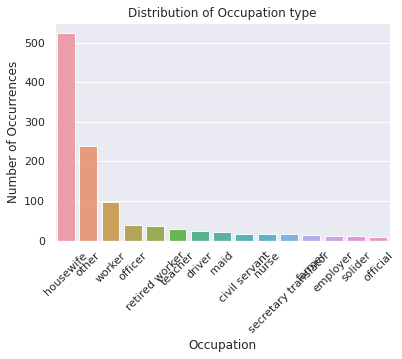

In [ ]:
occupation_count = df["Occupation_trans"].value_counts()
sns.set(style="darkgrid")
sns.barplot(occupation_count.index, occupation_count.values, alpha=0.9)
plt.title('Distribution of Occupation type')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Occupation', fontsize=12)
plt.xticks(rotation=45)
plt.show()

g) Focus on Exercise

In [ ]:
df['Exercise'].unique()

array(['0', '1-2/week', '3-4/week'], dtype=object)

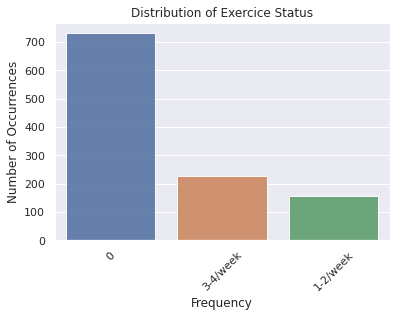

In [ ]:
exercice_count = df["Exercise"].value_counts()
sns.set(style="darkgrid")
sns.barplot(exercice_count.index, exercice_count.values, alpha=0.9)
plt.title('Distribution of Exercice Status')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Maybe we should group 3-4 times and 1-2/times together
# df.Exercise.replace({'0':'no', '1-2/week':'yes', '3-4/week':'yes'}, inplace=True)

h) Make dummies

In [ ]:
df.Hiperlipidemi.unique()

array([ 0.,  1., nan])

In [ ]:
df

,Age,Weight,Height,Waist,Hip,Smoking,Smoking (packet/year),Alcohol,DM,DM duration,...,Low grip strength,Grip strength,SARCOPENIA,STAR,BMI,Gender,Occupation_trans,Education_trans,Working_status_trans,missing_values_per_row
0,64,66.0,155.0,89.0,104.0,0.0,0.0,abstemious,0,0.0,...,0.0,28.0,0.0,1.00,27.4,f,officer,high school,retired,0
2,56,56.0,150.0,112.0,125.0,0.0,0.0,abstemious,0,0.0,...,0.0,23.0,0.0,1.48,36.0,f,housewife,illiterate,retired,0
3,58,75.0,160.0,113.0,NaN,0.0,0.0,abstemious,1,2.0,...,0.0,23.0,0.0,1.12,29.3,f,housewife,illiterate,unemployed,3
5,57,98.0,179.0,110.0,100.0,1.0,30.0,social,0,0.0,...,0.0,42.0,0.0,1.47,30.6,m,other,high school,retired,0
6,60,65.0,164.0,98.0,86.0,1.0,11.5,social,0,0.0,...,0.0,22.0,0.0,1.44,24.2,f,other,secondary school,working,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,87,54.0,148.0,93.0,98.0,0.0,0.0,abstemious,0,0.0,...,NaN,17.0,0.0,1.41,24.7,f,housewife,primary school,retired,6
1298,73,80.0,162.0,103.0,107.0,1.0,50.0,abstemious,1,22.0,...,1.0,30.0,1.0,1.31,30.5,m,solider,high school,retired,0
1299,61,87.0,158.0,107.0,128.0,1.0,45.0,abstemious,0,0.0,...,0.0,23.0,0.0,1.15,34.9,f,housewife,high school,retired,0
1300,66,70.0,166.0,96.0,101.0,1.0,46.0,social,0,0.0,...,1.0,29.0,1.0,1.15,25.4,m,other,primary school,retired,0


In [ ]:
df_dummies = pd.DataFrame()
for col in categorical_cols:
    dummy = pd.get_dummies(df[[col]])
    df_dummies = pd.concat([df_dummies, dummy], axis=1)

In [ ]:
df.drop(columns=categorical_cols, inplace=True)
df = pd.concat([df, df_dummies], axis=1)
df

,Age,Weight,Height,Waist,Hip,Smoking,DM,DM duration,İnsülin,Hiperlipidemi,...,Occupation_trans_teacher,Occupation_trans_worker,Education_trans_high school,Education_trans_illiterate,Education_trans_primary school,Education_trans_secondary school,Education_trans_university,Working_status_trans_retired,Working_status_trans_unemployed,Working_status_trans_working
0,64,66.0,155.0,89.0,104.0,0.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
2,56,56.0,150.0,112.0,125.0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,0,0
3,58,75.0,160.0,113.0,NaN,0.0,1,2.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
5,57,98.0,179.0,110.0,100.0,1.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
6,60,65.0,164.0,98.0,86.0,1.0,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,87,54.0,148.0,93.0,98.0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0
1298,73,80.0,162.0,103.0,107.0,1.0,1,22.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
1299,61,87.0,158.0,107.0,128.0,1.0,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
1300,66,70.0,166.0,96.0,101.0,1.0,0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,0,0


### 4) Scaling

In [ ]:
# Get categorical columns list
numerical_cols = []
categorical_cols = []
for col in df.columns:
    if(df[col].dtype == 'object'):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_col = scaler.fit_transform(df[numerical_cols])
scaled_df = pd.DataFrame(scaled_col, columns = numerical_cols)
df.drop(columns=numerical_cols, inplace=True)
df = pd.concat([df, scaled_df], axis=1)
df.head()

,Age,Weight,Height,Waist,Hip,Smoking,DM,DM duration,İnsülin,Hiperlipidemi,...,Occupation_trans_teacher,Occupation_trans_worker,Education_trans_high school,Education_trans_illiterate,Education_trans_primary school,Education_trans_secondary school,Education_trans_university,Working_status_trans_retired,Working_status_trans_unemployed,Working_status_trans_working
0,0.404255,0.222222,0.350877,0.329787,0.505682,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.234043,0.129630,0.263158,0.574468,0.625000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.276596,0.305556,0.438596,0.585106,NaN,0.0,1.0,0.05,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.255319,0.518519,0.771930,0.553191,0.482955,1.0,0.0,0.00,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.319149,0.212963,0.508772,0.425532,0.403409,1.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### 5) Imputation

In [ ]:
# Impute the values for the remaining columns using knn 
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [ ]:
# Cast everything as int instead of float
df = df.astype('int32')

## II. Model Prediction

Implement Logistic Regression, Random Forest, and Gradient Boosting on this dataset. You might plan to develop two separate models for men and women, as gender plays a significant role in Sarcopenia.

### '1) Model 1 : Basic infos

In [ ]:
#https://github.com/claudian37/DS_Portfolio/blob/master/credit_card_fraud/01_kaggle_creditcardfraud_modeling_final.ipynb

In [ ]:
df1 = df.copy()
df1.drop(columns=["LowCST","CST", "STAR", "Gait speed", "Low grip strength","Grip strength"], inplace=True)
y1 = df1['SARCOPENIA']
df1.drop(columns=["SARCOPENIA"], inplace=True)
X1 = df1

X_train, X_test, y_train, y_test = train_test_split(X1,y1,stratify=y1)

In [ ]:
# pipeline for numerical transformer
numeric_features = ['guild','total_timestamps', 'unique_days', 'max_level', 'Average_Hour', 'Average_Playing_density']
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
# construct the column transformer
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [ ]:
# assemble the end-to-end pipeline
clf = Pipeline(steps=[
    #('classifier', KNeighborsClassifier(n_neighbors = 3))
    ('classifier', LogisticRegression())
])

In [ ]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.83125

In [ ]:
param_grid = [{'classifier': [LogisticRegression()],
               'classifier__solver': ['lbfgs'],
               'classifier__penalty': ['l2'],
               'classifier__C': [0.001,0.01,0.1,1,10,100]},
               #'classifier__C': loguniform.rvs(1e-3, 1e0, size=100)},
              ]

#GridSearchCV(estimator, parameters to tune, cross validation fold)
grid_search = GridSearchCV(clf,param_grid,cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid=[{'classifier': [LogisticRegression(C=0.1)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2'],
                          'classifier__solver': ['lbfgs']}])

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8380263157894736
{'classifier': LogisticRegression(C=0.1), 'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [ ]:
gbrt = GradientBoostingClassifier()
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)
gbrt.score(X_test, y_test)

0.8125

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=0)
param_grid_rfc = { 
    'n_estimators': range(1,100,5),
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, cv= 10)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': range(1, 100, 5)})

In [ ]:
CV_rfc.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 21}

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
voting = VotingClassifier(
    [('logreg',LogisticRegression(C=0.1,penalty='l2',solver='lbfgs')),
    ('tree',RandomForestClassifier(n_estimators= 46,criterion='gini',max_depth=8, random_state=0)),],
    voting='soft')
voting.fit(X_train,y_train)
lr,tree=voting.estimators_
voting.score(X_test,y_test), lr.score(X_test,y_test),tree.score(X_test,y_test)   

(0.828125, 0.83125, 0.825)

Model1: Determine the probability that the patient has Sarcopenia based on variables available when the patient is home, such as age, weight, height, exercise, Hiper tension, DM, Education, Smoking.. Values for these variables can be obtained without the patient reporting physically to a clinic.At the end of Model1, diagnose patients with very high probability of developing Sarc as positive and very low probability of Sarc as negative. The remaining patients need further testing, so send them to the send model.

### 2) Model 2 : Basic infos + CST and GDP

In [ ]:
df2 = df.copy()
df2.drop(columns=["LowCST", "STAR", "Low grip strength","Grip strength"], inplace=True)
y2 = df2['SARCOPENIA']
df2.drop(columns=["SARCOPENIA"], inplace=True)
X2 = df2

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2,y2,stratify=y2)

In [ ]:
#pipeline for numerical transformer
numeric_features = ['guild','total_timestamps', 'unique_days', 'max_level', 'Average_Hour', 'Average_Playing_density']
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
# construct the column transformer
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [ ]:
clf.fit(X_train_2, y_train_2)
clf.score(X_test_2, y_test_2)

0.828125

In [ ]:
grid_search = GridSearchCV(clf,param_grid,cv=10)
grid_search.fit(X_train_2,y_train_2)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid=[{'classifier': [LogisticRegression(C=0.1)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2'],
                          'classifier__solver': ['lbfgs']}])

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8338486842105264
{'classifier': LogisticRegression(C=0.1), 'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [ ]:
gbrt = GradientBoostingClassifier()
gbrt.fit(X_train_2, y_train_2)
gbrt.score(X_test_2, y_test_2)

0.828125

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, cv= 10)
CV_rfc.fit(X_train_2, y_train_2)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': range(1, 100, 5)})

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 26}

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
voting = VotingClassifier(
    [('logreg',LogisticRegression(C=0.1,penalty='l2',solver='lbfgs')),
    ('tree',RandomForestClassifier(n_estimators= 6,criterion='entropy',max_depth=8, random_state=0))],
    voting='soft')
voting.fit(X_train_2,y_train_2)
lr,tree=voting.estimators_
voting.score(X_test_2,y_test_2), lr.score(X_test_2,y_test_2),tree.score(X_test_2,y_test_2)    


(0.828125, 0.83125, 0.821875)

Model 2: Predict the Sarcopenia probability including CST and GSP. To measure CST, “Chair Stand Test”, a physician times a patient when she sits and stands up on a chair five times. To measure GDP, “Gait speed test”, a physician times a patient when she walks a certain distance. We are provided with these two features in the dataset. In the second model, in addition to the variables we used in the first model, we will include CST and GDP.

### 3) Model 3 : Basic infos + CST + GDP + GRS

Model 3: Predict the Sarcopenia including ‘GRS’, Grip Strength Test. A physician measures the grp strength of a patient using a gyro hand grip. We will include GRS into our model with all the variables from Model2.

In [ ]:
df3 = df.copy()
df3.drop(columns=["LowCST", "STAR", "Low grip strength"], inplace=True)
y3 = df3['SARCOPENIA']
df3.drop(columns=["SARCOPENIA"], inplace=True)
X3 = df3

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3,y3,stratify=y3)

In [ ]:
clf.fit(X_train_3, y_train_3)
clf.score(X_test_3, y_test_3)

0.840625

In [ ]:
grid_search = GridSearchCV(clf,param_grid,cv=10)
grid_search.fit(X_train_3,y_train_3)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid=[{'classifier': [LogisticRegression(C=100)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__penalty': ['l2'],
                          'classifier__solver': ['lbfgs']}])

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8390679824561402
{'classifier': LogisticRegression(C=100), 'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [ ]:
gbrt = GradientBoostingClassifier()
gbrt.fit(X_train_3, y_train_3)
gbrt.score(X_test_3, y_test_3)

0.809375

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, cv= 10)
CV_rfc.fit(X_train_3, y_train_3)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': range(1, 100, 5)})

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 36}

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
voting = VotingClassifier(
    [('logreg',LogisticRegression(C=0.1,penalty='l2',solver='lbfgs')),
    ('tree',RandomForestClassifier(n_estimators= 21,criterion='gini',max_depth=7, random_state=0))],
    voting='soft')
voting.fit(X_train_3,y_train_3)
lr,tree=voting.estimators_
voting.score(X_test_3,y_test_3), lr.score(X_test_3,y_test_3),tree.score(X_test_3,y_test_3)   

(0.828125, 0.8375, 0.828125)

In [ ]:
y_pred_3=voting.predict(X_test_3)

### 4) Models evaluation

So, in sum, we start with a patient pool, we first eliminate the ones that we are almost certain whether they have Sarcopenia or not. Next, the remaining patients go through Model 2 and we again eliminate the patients that we are almost certain whether they have Sarcopenia or not. We will repeat the same procedure for Model 3. The remaining patients after Model 3 will go through ultrasound process to measure their muscle thickness, which will increase the certainty for diagnosing whether they have Sarcopenia. Our goal is, making the diagnosis as much as possible and reduce number of patients going through extra tests.

In your deliverable, report precision, recall, f1, and auc scores. Report feature with a bar graph.


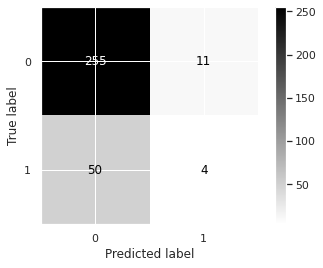

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gbrt,X_test_3,y_test_3,cmap='gray_r')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_3,y_pred_3))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       266
           1       0.00      0.00      0.00        54

    accuracy                           0.83       320
   macro avg       0.42      0.50      0.45       320
weighted avg       0.69      0.83      0.75       320



TypeError: unsupported operand type(s) for +: 'int' and 'function'

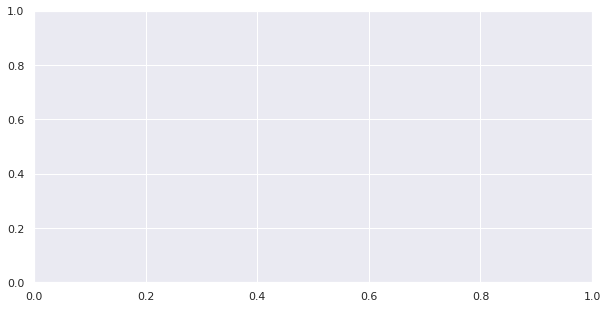

In [ ]:
plt.figure(figsize=(10,5))
plt.barh(range(4),classification_report)
plt.yticks(range(4), classification_report)

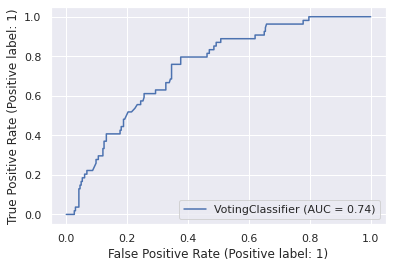

In [ ]:
from sklearn.metrics import plot_roc_curve, auc
plot_roc_curve(gbrt,X_test_3,y_test_3,name = 'VotingClassifier')

In [ ]:
roc_auc_score(y_test, y_pred_3)

0.4981203007518797

In [ ]:
rfc_3=RandomForestClassifier(n_estimators= 21,criterion='gini',max_depth=7, random_state=0)
rfc_3.fit(X_train_3, y_train_3)

RandomForestClassifier(max_depth=7, n_estimators=21, random_state=0)

AttributeError: 'DataFrame' object has no attribute 'feature_names'

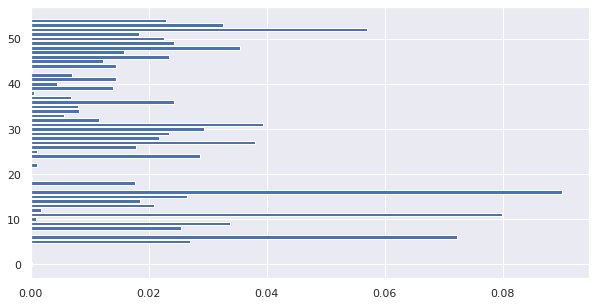

In [ ]:
plt.figure(figsize=(10,5))
plt.barh(range(55),rfc_3.feature_importances_)
plt.yticks(range(55), df3.feature_names)

In [ ]:
As our model is does not provide very good results, for example the F1 value, we would continue with regularization
, data augmentation or sampling.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3936dca8-42ca-41a4-aad6-22f3c31c57fb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>